In [2]:
import os
import math
import warnings
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

warnings.filterwarnings("ignore")

In [3]:
def load(file_name, header=None) -> pd.DataFrame:
    """Loading dataset
    @param file_name: user input dataset
    @return: dataset
    """
    if os.path.exists(file_name) == False:
        raise ValueError("Entered File is not found")
    if os.path.isdir(file_name):
        raise ValueError("Entered string is a directory")
    if header == False:
        return pd.read_csv(file_name, header=None)
    return pd.read_csv(file_name)

def copy_df(df) -> pd.DataFrame:
    """copy df to new temp df
    @param df: user input dataset
    @return: new df
    """
    return df.copy(deep=True)

def normalize_missing_values(dataset) -> pd.DataFrame:
    """normalize dataset missing values with mean for numerical columns
    @param dataset: user input dataset
    @return: normalized dataset
    """
    for col in dataset.columns:
        # print("column: ",col, "type: ", dataset[col].dtype)
        if dataset[col].dtype == 'object':
            dataset[col] = dataset[col].fillna(method='bfill')
        else:
            dataset[col] = dataset[col].fillna(dataset[col].mean()) 
    return dataset

def print_dataset(dataset):
    """print dataset inforamtion
    @param dataset: user input dataset
    @return: print dataset information via head(), info(), shape()
    """
    print(dataset.head())
    print(dataset.info())
    print(dataset.describe())
    print(dataset.columns)
    print(dataset.iloc[:, -1].value_counts())

def dummy_variable_indicator(data, column_name) -> pd.DataFrame:
    """dummy variable indicator
    @param data: user input data
    @param column_name: column name
    @return: data with dummy variable indicator
    """
    if column_name not in data.columns:
        raise ValueError("Column not found")
    data = pd.get_dummies(data, columns=[column_name])
    return data

def remove_column(data, column_name) -> pd.DataFrame:
    """remove column
    @param data: user input data
    @param column_name: column name
    @return: data without column
    """
    if column_name not in data.columns:
        raise ValueError("Column not found")
    data = data.drop(column_name, axis=1)
    return data

def normalize_numerical_columns(data) -> pd.DataFrame:
    """normalize numerical columns to 0-1 scale
    @param data: user input data
    @return: normalized data
    """
    for col in data.columns:
        if data[col].dtype == 'int64' or data[col].dtype == 'float64':
            data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())
    return data

def concat_data(x_data, y_data) -> list:
    """
    @param x_data: feature data
    @param y_data: label data
    @return: concatenation of features and label data
    """
    return pd.concat([x_data, y_data], axis=1)

def train_test_split(data, train_size=None, test_size=None, random_state=None, shuffle=None) -> tuple:
    """split dataset into train, validation and test
    @param data: user input dataset
    @param train_size: user input train size
    @param test_size: user input test size
    @param random_state: user input random state
    @return: train, validation and test dataset
    """
    if train_size is None and test_size is None:
        raise ValueError("train_size and test_size can not be both None")
    if train_size is not None and test_size is not None and train_size + test_size > 1:
        raise ValueError("train_size and test_size sum must be equal to 1")
    if train_size is not None and test_size is not None and train_size + test_size < 1:
        raise ValueError("train_size and test_size sum is not equal to one")
    if train_size is not None:
        if train_size <= 0:
            raise ValueError("train_size must be greater than 0")
        if train_size >= 1:
            raise ValueError("train_size must be less than 1")
        if test_size is None:
            test_size = 1 - train_size
        elif test_size <= 0:
            raise ValueError("test_size must be greater than 0")
        elif test_size >= 1:
            raise ValueError("test_size must be less than 1")
    if test_size is not None:
        if test_size <= 0:
            raise ValueError("test_size must be greater than 0")
        if test_size >= 1:
            raise ValueError("test_size must be less than 1")
        if train_size is None:
            train_size = 1 - test_size
        elif train_size <= 0:
            raise ValueError("train_size must be greater than 0")
        elif train_size >= 1:
            raise ValueError("train_size must be less than 1")
    train_size = int(len(data) * train_size)
    test_size = int(len(data) * test_size)
    if shuffle is True:
        data = data.sample(frac=1).reset_index(drop=True)
    
    # print("train_size: ", train_size, "test_size: ", test_size, 'sum: ', train_size + test_size)
    train_index = np.random.choice(len(data), train_size, replace=False)
    
    # split train data
    x_train = data.iloc[train_index, :-1].reset_index(drop=True)
    # x_train = data.drop(, axis=1).iloc[train_index].reset_index(drop=True)
    y_train = data.iloc[train_index, -1:].reset_index(drop=True)
    
    # differnetiate train indexes from whole data indexes
    test_index = np.setdiff1d(np.arange(len(data)), train_index)

    # split test data
    x_test = data.iloc[test_index, :-1].reset_index(drop=True)
    # x_test = data.drop('median_house_value', axis=1).iloc[test_index].reset_index(drop=True)
    y_test = data.iloc[test_index, -1:].reset_index(drop=True)
    return x_train, y_train, x_test, y_test

def k_fold(data, k_fold_number):
    pass
#     x_train_list, x_test_list, y_train_list, y_test_list, x_validation_list, y_validation_list  = [], [], [], [], [], []
#     for _ in range(k_fold_number):
#         intermediate_data = copy_df(data)

#         # split data into train, validation and test
#         x_train, y_train, x_validation_test, y_validation_test = train_test_split(intermediate_data, train_size=.6, shuffle=True)
#         x_validation, y_validation, x_test, y_test = train_test_split(concat_data(x_validation_test, y_validation_test), test_size=.5, shuffle=True)

#         x_train_list.append(x_train)
#         x_test_list.append(x_test)
#         y_train_list.append(y_train)
#         y_test_list.append(y_test)
#         x_validation_list.append(x_validation)
#         y_validation_list.append(y_validation)
#     return x_train_list, y_train_list, x_test_list, y_test_list, x_validation_list, y_validation_list

# def print_k_fold_data(x_train_list, y_train_list, x_test_list, y_test_list, x_validation_list, y_validation_list):
#     """print k-fold data
#     @param x_train_list: train data
#     @param y_train_list: train label 
#     @param x_test_list: test data
#     @param y_test_list: test label 
#     @param x_validation_list: validation data
#     @param y_validation_list: validation label 
#     """
#     k_fold_number = len(x_train_list)
#     for index in range(k_fold_number):
#         print("================== K-fold {} ==================".format(index + 1))
#         print("x_train_list[", index, "]: ", x_train_list[index].shape, "y_train_list[", index, "]: ", y_train_list[index].shape)
#         print("x_validation_list[", index, "]: ", x_validation_list[index].shape, "y_validation_list[", index, "]: ", y_validation_list[index].shape)
#         print("x_test_list[", index, "]: ", x_test_list[index].shape, "y_test_list[", index, "]: ", y_test_list[index].shape)
#         print(f"sum: {x_train_list[index].shape[0] + x_validation_list[index].shape[0] + x_test_list[index].shape[0]}")

def reshape_to_1d(*arrays):
    """
    Reshape all arrays to 1D
    @param arrays: input arrays
    @return: reshaped arrays
    """
    return [np.reshape(array, (array.shape[0],)) for array in arrays]

def print_hypothesis(x_data, theta):
    """Print hypothesis
    @param x_data: x_data
    @param theta: wights
    """
    H_x = "H(x) = " + "{:.2f}".format(theta[0]) + " + "
    for index in range(1, x_data.shape[1]):
        if (index+1) != x_data.shape[1]:
            H_x += "{:.2f}".format(theta[index]) + f"*x_{index} + "
        else:
            H_x += "{:.2f}".format(theta[index]) + f"*x_{index}"
    print(H_x)

def hypothesis(x_data, theta_or_weight):
    """Hypothesis function
    @param x_data: train data
    @param theta_or_weight: parameter
    """
    return np.dot(x_data, theta_or_weight)

def loss_function_with_regularization(x_data, y_data, theta, regularization_parameter):
    """Loss Function with regularization
    @param x_data: train data
    @param y_data: train label
    @param theta: weights
    @param regularization_parameter: lambda regularization parameter
    @return: loss function value
    """
    m_number_of_samples = x_data.shape[0]
    j_theta_1_mse_loss = np.sum(np.square(hypothesis(x_data, theta) - y_data)) / 2 * m_number_of_samples
    j_theta_2_regularization_loss = (regularization_parameter / (2 * m_number_of_samples)) * np.sum(np.square(theta))
    return j_theta_1_mse_loss + j_theta_2_regularization_loss

def loss_function(x_data, y_data, theta):
    """Loss Function without regularization
    @param x_data: train data
    @param y_data: train label
    @param theta: weights
    @return: loss function value
    """
    m_number_of_samples = x_data.shape[0]
    j_theta_1_mse_loss = np.sum(np.square(hypothesis(x_data, theta) - y_data)) / 2 * m_number_of_samples
    return j_theta_1_mse_loss

def gradient_descent(x_train, y_train, x_validation, y_validation, theta, regularization_parameter, alpha, max_iteration):
    """gradient_descent
    @param x_train: train data
    @param y_train: train label
    @param x_validation: validation data
    @param y_validation: validation label
    @param theta: wieghts
    @param regularization_paramet: lambda regularization parameter
    @param alpha: learning rate
    @param max_iteration: epochs
    @return: updated wieghts and loss function value
    """
    m_number_of_samples = x_train.shape[0]
    theta_dict = {}
    evaluation_with_validation_set_list = []

    with tqdm (total=max_iteration) as progress_bar:
        for iteration in range(max_iteration):
            hypothesis_value = hypothesis(x_train, theta)

            # updating θ_j with regularization
            for j_index in range(theta.shape[0]):
                if j_index != 0:
                    theta[j_index] -= alpha *  (1 / m_number_of_samples) * (np.dot(hypothesis_value - y_train, x_train[:, j_index]) + regularization_parameter * theta[j_index])
                else:
                    theta[j_index] -= alpha *  (1 / m_number_of_samples) * np.dot(hypothesis_value - y_train, x_train[:, j_index])

            evaluation_with_validation_set_list.append(loss_function_with_regularization(x_validation, y_validation, theta, regularization_parameter))
            theta_dict[iteration] = theta

            if len(evaluation_with_validation_set_list) >= 8:
                treshold_list = np.array(evaluation_with_validation_set_list[-8:])
                if treshold_list[-1 and -2 and -3 and -4 and -5 and -6 and -7] > treshold_list[-8]:

                    # if alpha > 1e-3:
                        # feedback = f"learning rate is too high, reducing it from {alpha}"
                        # alpha /= 2
                        # feedback += f" to {alpha} in iteration {iteration}"
                        # print(feedback)
                        # continue

                    print("iteration: ", iteration, "regularization_parameter: ", regularization_parameter, "alpha: ", alpha,  "loss: ", evaluation_with_validation_set_list[-1])
                    return theta, theta_dict, evaluation_with_validation_set_list

            if len(evaluation_with_validation_set_list) >= 10:
                plateau_list = np.array(evaluation_with_validation_set_list[-10:])
                if np.all(plateau_list == plateau_list[0]):

                    print("plateau: ", plateau_list)
                    # alpha *= 2
                    print("iteration: ", iteration, "regularization_parameter: ", regularization_parameter, "alpha: ", alpha,  "loss: ", evaluation_with_validation_set_list[-1])
                    return theta, theta_dict, evaluation_with_validation_set_list

            progress_bar.update(1)
        print("regularization_parameter: ", regularization_parameter, "alpha: ", alpha,  "loss: ", evaluation_with_validation_set_list[-1])
    return theta, theta_dict, evaluation_with_validation_set_list


# =============================== error functions ===============================
def calculate_r_squared(y_predict, y_test):
    """
    calculate r squared
    @param y_predict: predict value
    @param y_test: test value
    @return: r squared
    """
    return 1 - (np.sum(np.square(y_predict - y_test)) / np.sum(np.square(y_test - np.mean(y_test))))

def calculate_mse(y_predict, y_test):
    """
    calculate mse
    @param y_predict: predict value
    @param y_test: test value
    @return: mse
    """
    return np.sum(np.square(y_predict - y_test)) / y_test.shape[0]

def calculate_rmse(y_predict, y_test):
    """
    calculate rmse
    @param y_predict: predict value
    @param y_test: test value
    @return: rmse
    """
    return np.sqrt(calculate_mse(y_predict, y_test))

def calculate_mae(y_predict, y_test):
    """
    calculate mae
    @param y_predict: predict value
    @param y_test: test value
    @return: mae
    """
    return np.sum(np.abs(y_predict - y_test)) / y_test.shape[0]

def calculate_mape(y_predict, y_test):
    """
    calculate mape
    @param y_predict: predict value
    @param y_test: test value
    @return: mape
    """
    return np.sum(np.abs((y_predict - y_test) / y_test)) / y_test.shape[0]

def report_difference(y_predict, y_test):
    inter_report = pd.DataFrame({"y_predict": y_predict, "y_test": y_test})
    inter_report["difference"] = inter_report["y_predict"] - inter_report["y_test"]
    inter_report["difference_percentage"] = inter_report["difference"] / inter_report["y_test"]
    return inter_report

def report_difference_mean(report):
    return {"difference": np.round(report["difference"].mean(), 2), "difference_percentage": np.round(report["difference"].mean() / report["y_test"].mean(), 2)}

In [4]:
# print(">======================= Loading ====================<")
dataset = load("housing.csv")
# print(">====================================================<")

# print(">================= preprocessing ====================<")
# print(">============= handling missing values ==============<")
dataset = normalize_missing_values(dataset)
last_column = dataset[["median_house_value"]]
dataset = remove_column(dataset, "median_house_value")
# print(">====================================================<")

# print(">======= One-hot encoder for categorical data =======<")
dataset = dummy_variable_indicator(dataset, "ocean_proximity")
dataset = remove_column(dataset, "ocean_proximity_INLAND")
dataset = concat_data(dataset, last_column)
dataset_for_part_h = copy_df(dataset)
dataset = dataset.assign(median_house_value = dataset["median_house_value"] / dataset["median_house_value"].max())
last_column = dataset[["median_house_value"]]
dataset = remove_column(dataset, "median_house_value")
dataset = normalize_numerical_columns(dataset)
dataset = concat_data(dataset, last_column)

dataset.insert(0, "theta_0", np.ones(dataset.shape[0]))
feature_columns = dataset.drop('median_house_value', axis=1).columns
# print(">====================================================<")

# print(">=========== split data to 60% train,20% validation and 20% test ===========<")
x_train, y_train, x_validation_test, y_validation_test = train_test_split(copy_df(dataset), train_size=.6, shuffle=True)
x_validation, y_validation, x_test, y_test = train_test_split(concat_data(x_validation_test, y_validation_test), test_size=.5, shuffle=True)

# convert all data to np array
x_train, y_train, x_validation, y_validation, x_test, y_test = np.array(x_train), np.array(y_train), np.array(x_validation), np.array(y_validation), np.array(x_test), np.array(y_test)

y_train, y_test, y_validation, = reshape_to_1d(y_train, y_test, y_validation)
# print(">===========================================================================<")

In [25]:
# print(">=================== Initialize model fitting ===================<")
theta = np.random.rand(x_train.shape[1]) # random values between 0 and 1 
# theta = np.random.rand(x_train.shape[1]) * 5 + 5 # random values between 5 and 10
# theta = np.random.rand(x_train.shape[1]) * 1 + 2 # random values between 2 and 3
regul_param_list = [0, 0.01, 0.1, 5, 10, 100]
alpha_list = [.1, .3, .5, .7, .9, 1]
max_iteration = 10000
# print(">===========================================================================<")

def report_gradient_descent(x_train, y_train, x_validation, y_validation, theta, regularization_parameter_list, alpha_list, max_iteration):
    theta_list = []
    loss_list = []
    report_data_frame = pd.DataFrame(columns=["regularization_parameter", "alpha", "theta_history", "loss"])
    counter = 0 
    for regularization_parameter in regularization_parameter_list:
        for alpha in alpha_list:
            theta_, theta_history, loss_histoy = gradient_descent(x_train, y_train, x_validation, y_validation, theta, regularization_parameter=regularization_parameter, alpha=alpha, max_iteration=max_iteration)
            loss_list.append(loss_histoy)
            theta_list.append({counter: [*theta_]})
            report_data_frame.loc[len(report_data_frame)] = [regularization_parameter, alpha, theta_history, loss_histoy]
            counter += 1

    return report_data_frame, theta_list, loss_list

report_df, theta_list, loss_list = report_gradient_descent(x_train, y_train, x_validation, y_validation, theta, regul_param_list, alpha_list, max_iteration)

  0%|          | 0/10000 [00:00<?, ?it/s]

regularization_parameter:  0 alpha:  0.1 loss:  247.8758926677736


  0%|          | 0/10000 [00:00<?, ?it/s]

regularization_parameter:  0 alpha:  0.3 loss:  226.53064828448234


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  7882 regularization_parameter:  0 alpha:  0.5 loss:  224.42718146323594


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  7 regularization_parameter:  0 alpha:  0.7 loss:  224.42718576264795


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  7 regularization_parameter:  0 alpha:  0.9 loss:  224.4271966895424


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  7 regularization_parameter:  0 alpha:  1 loss:  224.42721590721825


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  7 regularization_parameter:  0.01 alpha:  0.1 loss:  224.4292140706553


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  7 regularization_parameter:  0.01 alpha:  0.3 loss:  224.4336865046011


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  7 regularization_parameter:  0.01 alpha:  0.5 loss:  224.4382509092659


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  7 regularization_parameter:  0.01 alpha:  0.7 loss:  224.44086463929082


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  7 regularization_parameter:  0.01 alpha:  0.9 loss:  224.43952066219626


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  1429 regularization_parameter:  0.01 alpha:  1 loss:  223.86033082709488


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  7 regularization_parameter:  0.1 alpha:  0.1 loss:  223.87879920472895


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  7 regularization_parameter:  0.1 alpha:  0.3 loss:  223.9202481106542


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  7 regularization_parameter:  0.1 alpha:  0.5 loss:  223.96291073247576


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  7 regularization_parameter:  0.1 alpha:  0.7 loss:  223.9881047250908


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  7 regularization_parameter:  0.1 alpha:  0.9 loss:  223.97724230817113


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  738 regularization_parameter:  0.1 alpha:  1 loss:  220.30765285197174


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  7 regularization_parameter:  5 alpha:  0.1 loss:  221.55429789657222


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  7 regularization_parameter:  5 alpha:  0.3 loss:  225.2634268047968


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  7 regularization_parameter:  5 alpha:  0.5 loss:  232.02137825172142


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  7 regularization_parameter:  5 alpha:  0.7 loss:  242.2624267852781


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  7 regularization_parameter:  5 alpha:  0.9 loss:  255.64450786605795


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  7 regularization_parameter:  5 alpha:  1 loss:  270.8121986885318


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  7 regularization_parameter:  10 alpha:  0.1 loss:  276.6016996484987


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  7 regularization_parameter:  10 alpha:  0.3 loss:  294.28349238770664


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  7 regularization_parameter:  10 alpha:  0.5 loss:  324.0598583221632


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  7 regularization_parameter:  10 alpha:  0.7 loss:  364.84152408132786


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  7 regularization_parameter:  10 alpha:  0.9 loss:  414.0239180923391


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  7 regularization_parameter:  10 alpha:  1 loss:  462.691618635682


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  7 regularization_parameter:  100 alpha:  0.1 loss:  569.0155564410403


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  7 regularization_parameter:  100 alpha:  0.3 loss:  815.6517837559313


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  7 regularization_parameter:  100 alpha:  0.5 loss:  1319.1409415663213


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  7 regularization_parameter:  100 alpha:  0.7 loss:  1641.954756025176


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  42 regularization_parameter:  100 alpha:  0.9 loss:  3924.3020870114833


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  7 regularization_parameter:  100 alpha:  1 loss:  869.8038175092684


In [27]:
# import subprocess

for index in range(len(report_df)):

    plt.figure(figsize=(12, 10))
    plt.plot(report_df.iloc[index]['loss'], label="loss")
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.legend(["loss"], loc="upper left")
    plt.title("Loss graph - lambda: " + str(report_df.iloc[index]['regularization_parameter']) + " alpha: " + str(report_df.iloc[index]['alpha']))
    plt.savefig("./images/lambda_" + str(report_df.iloc[index]['regularization_parameter']) + "_alpha_" + str(report_df.iloc[index]['alpha']) + "_loss.png")
    # plt.show()
    plt.close()
    
    # unpacking theta_list[i] to coeff
    coeff = [*theta_list[index].values()][0]

    plt.figure(figsize=(12, 10))
    # plt.plot([0, 1], [0, 1], 'k--')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4, label='Prediction') 
    plt.scatter(y_test, hypothesis(x_test, coeff), label="test")
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.legend(["Prediction"], loc="upper left")
    plt.title("Prediction - lambda: " + str(report_df.iloc[index]['regularization_parameter']) + " alpha: " + str(report_df.iloc[index]['alpha']))
    plt.savefig("./images/lambda_" + str(report_df.iloc[index]['regularization_parameter']) + "_alpha_" + str(report_df.iloc[index]['alpha']) + "_prediction.png")
    # plt.show()
    plt.close()

    plt.figure(figsize=(12, 10))
    plt.plot(range(len(coeff)), coeff, label="coefficient")
    plt.axhline(0, color='r', linestyle='solid')         # draw a horizontal line at y = 0
    plt.xticks(range(len(feature_columns)), feature_columns, rotation=90) # set the x ticks with names of columns
    plt.xlabel("feature")
    plt.ylabel("coefficents")
    plt.legend(["coefficients"], loc="upper left")
    plt.title("Coefficients - lambda: " + str(report_df.iloc[index]['regularization_parameter']) + " alpha: " + str(report_df.iloc[index]['alpha']))
    plt.savefig("./images/lambda_" + str(report_df.iloc[index]['regularization_parameter']) + "_alpha_" + str(report_df.iloc[index]['alpha']) + "_coefficient.png")
    # plt.show()
    plt.close()

# subprocess.call(["ffmpeg", "-framerate", "1", "-pattern_type", "glob", "-i", "*_coefficient.png", "-c:v", "libx264", "-pix_fmt", "yuv420p", "coefficient.mp4", "-y"])
# subprocess.call(["ffmpeg", "-framerate", "1", "-pattern_type", "glob", "-i", "*_prediction.png", "-c:v", "libx264", "-pix_fmt", "yuv420p", "prediction.mp4", "-y"])
# subprocess.call(["ffmpeg", "-framerate", "1", "-pattern_type", "glob", "-i", "*_loss.png", "-c:v", "libx264", "-pix_fmt", "yuv420p", "loss.mp4", "-y"])

# ffmpeg -framerate 1 -pattern_type glob -i "*_coefficient.png" -c:v libx264 -pix_fmt yuv420p coefficient.mp4 -y ; ffmpeg -framerate 1 -pattern_type glob -i "*_prediction.png" -c:v libx264 -pix_fmt yuv420p prediction.mp4 -y ; ffmpeg -framerate 1 -pattern_type glob -i "*_loss.png" -c:v libx264 -pix_fmt yuv420p loss.mp4 -y


print("[Done ☑]")


[Done ☑]


## Q1 - Part H

Error on test set: 
         mse      rmse       mae      mape  r_squared
0  0.021407  0.146311  0.105633  0.329554   0.624752


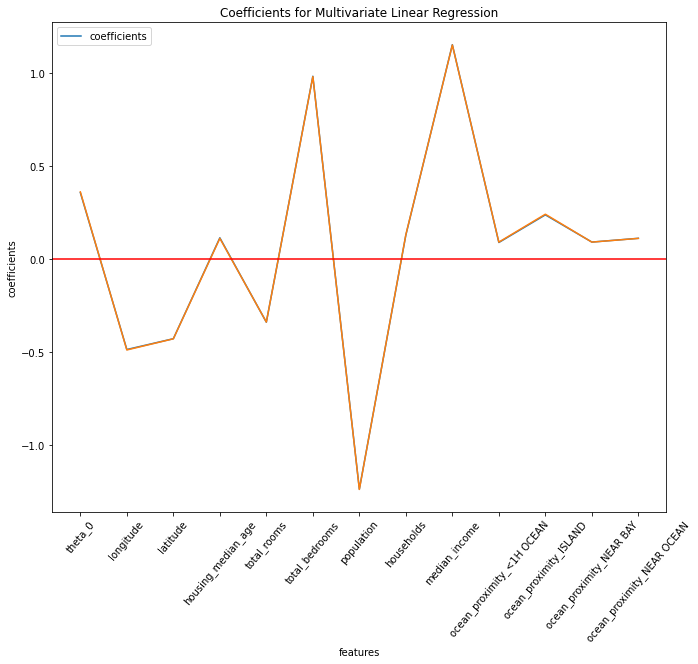

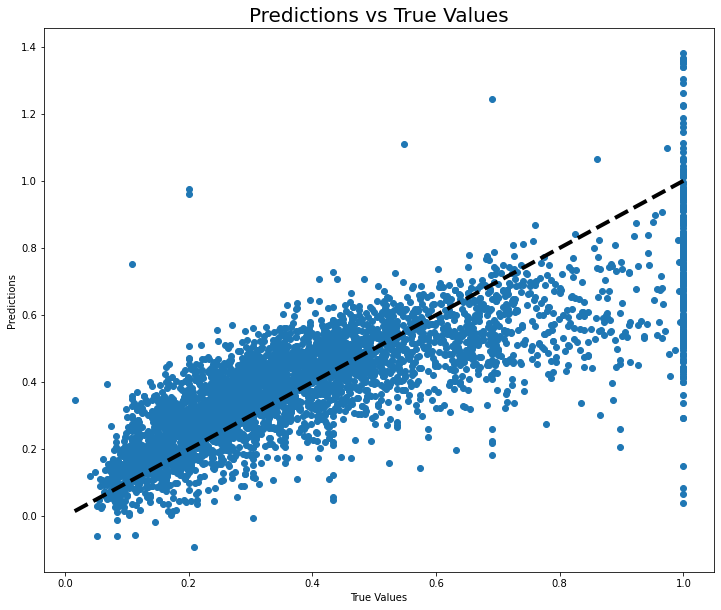

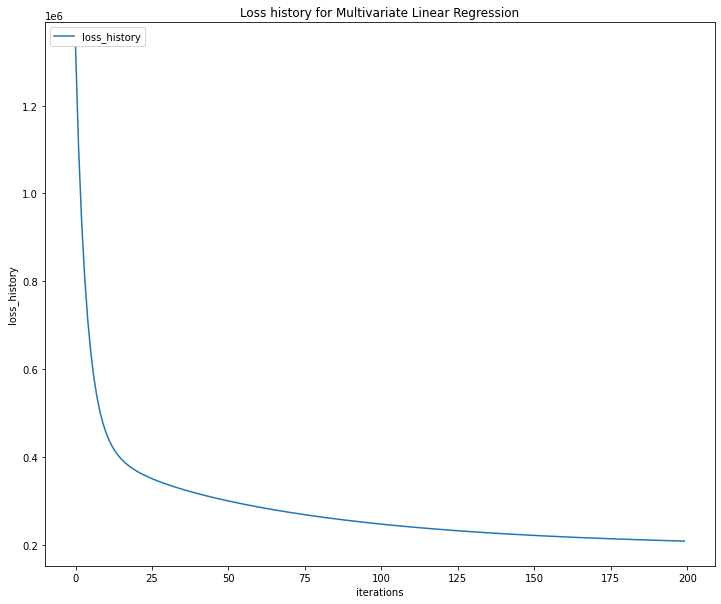

In [9]:
last_column_for_part_h = dataset_for_part_h[["median_house_value"]]
dataset_for_part_h = remove_column(dataset_for_part_h, "median_house_value")
dataset_for_part_h["population_per_household"] = dataset_for_part_h["population"] / dataset_for_part_h["households"]
dataset_for_part_h["rooms_per_household"] = dataset_for_part_h["total_rooms"] / dataset_for_part_h["households"]
dataset_for_part_h = concat_data(dataset_for_part_h, last_column_for_part_h)
dataset_for_part_h = normalize_numerical_columns(dataset_for_part_h)

y_predict = hypothesis(x_test, theta)
y_test = np.array(y_test).reshape(y_test.shape[0],)

report_error = pd.DataFrame({"mse": [calculate_mse(y_predict, y_test)], "rmse": [calculate_rmse(y_predict, y_test)], "mae": [
                            calculate_mae(y_predict, y_test)], "mape": [calculate_mape(y_predict, y_test)], "r_squared": [calculate_r_squared(y_predict, y_test)]})
print("Error on test set: \n", report_error)

# report = report_difference(y_predict, y_test)
# report_diff_mean = report_difference_mean(report)
# print(report)
# print("difference mean: ",report_diff_mean)
# print(theta_history[:10]) 

coeffs = pd.DataFrame({"theta": theta_history[-1], "coeff": theta_history[-1]})
coeffs["coeff"] = coeffs["coeff"].apply(lambda x: np.round(x, 2))
# print(coeffs)

# for i in range(10):
#     plt.figure(figsize=(10, 6))
#     plt.scatter(y_test, hypothesis(x_test, theta_history[i]))
#     clear_output(wait=True)
#     plt.plot([y_test.min(), y_test.max()], [y_predict.min(), y_predict.max()], 'k--', lw=4)
#     # plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
#     plt.xlabel('True Values')
#     plt.ylabel('Predictions')
#     # save images in ./images 
#     plt.savefig("./images/plot_" + str(i) + ".png")

loss_function_with_last_theta = loss_function(x_train, y_train, theta_history[-1])

# rescale coeffs to 0-1 range
# coeffs["coeff"] = coeffs["coeff"].apply(lambda x: (x - min(coeffs["coeff"])) / (max(coeffs["coeff"]) - min(coeffs["coeff"])))

# ffmpeg -framerate 30 -pattern_type glob -i 'plot_*.png' -c:v libx264 -pix_fmt yuv420p out.mp4 ####30 fps####
# import subprocess
# subprocess.call(["ffmpeg", "-framerate", "30", "-pattern_type", "glob", "-i", "plot_*.png", "-c:v", "libx264", "-pix_fmt", "yuv420p", "out.mp4"])

# print(">===================== Figures =====================<")
# default plot
plt.figure(figsize=(11, 9))
plt.plot(range(len(coeffs)), coeffs)
plt.axhline(0, color='r', linestyle='solid')
plt.xticks(range(len(feature_columns)), feature_columns, rotation=50)
plt.ylabel("coefficients")
plt.xlabel("features")
plt.title("Coefficients for Multivariate Linear Regression")
plt.legend(["coefficients"], loc="upper left")
plt.show()

plt.figure(figsize=(12, 10))
plt.scatter(y_test, y_predict)
plt.plot([y_test.min(), y_test.max()], [
         y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions vs True Values', fontsize=20)
plt.show()

loss_histoy = loss_histoy[:200]

# use .1 of the loss_history for xticks and .1 of the loss_history for yticks
plt.figure(figsize=(12, 10))
plt.plot(range(len(loss_histoy)), loss_histoy)
# plt.axhline(0, color='r', linestyle='solid')
# plt.xticks([])
# plt.xticks(range(len(loss_histoy)), range(len(loss_histoy)), rotation=50)
plt.xlabel("iterations")
plt.ylabel("loss_history")
plt.title("Loss history for Multivariate Linear Regression")
plt.legend(["loss_history"], loc="upper left")
plt.show()
# print(">===================================================<")

Intial theta shape:  15 
 Intial theta:  [0.45870181 0.75122324 0.62520795 0.26118484 0.93000734 0.68121598
 0.86560607 0.88351714 0.79034249 0.62894401 0.82442214 0.16823459
 0.28767881 0.62027892 0.52131901]
H(x) = 0.46 + 0.75*x_1 + 0.63*x_2 + 0.26*x_3 + 0.93*x_4 + 0.68*x_5 + 0.87*x_6 + 0.88*x_7 + 0.79*x_8 + 0.63*x_9 + 0.82*x_10 + 0.17*x_11 + 0.29*x_12 + 0.62*x_13 + 0.52*x_14


  0%|          | 0/10000 [00:00<?, ?it/s]

last theta:  [ 3.96159750e-01 -5.40222402e-01 -4.78291707e-01  1.10199832e-01
 -3.73233185e-01  7.83742154e-01 -1.69200519e+00  5.48880543e-01
  1.13550232e+00  8.48603004e-02  6.21450317e-01  8.41798448e-02
  9.80751699e-02  7.74662581e-04  3.86054381e-01]
Error on test set: 
         mse      rmse      mae  mape  r_squared
0  0.021057  0.145109  0.10427   inf   0.649057


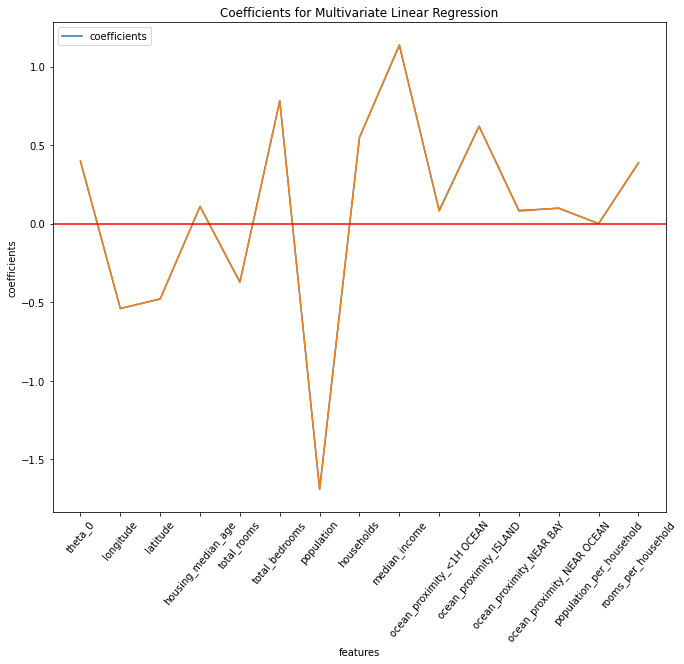

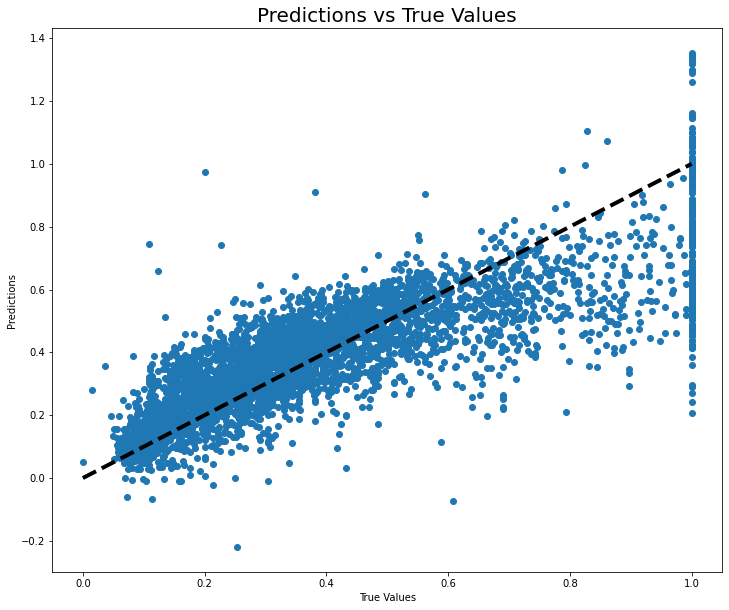

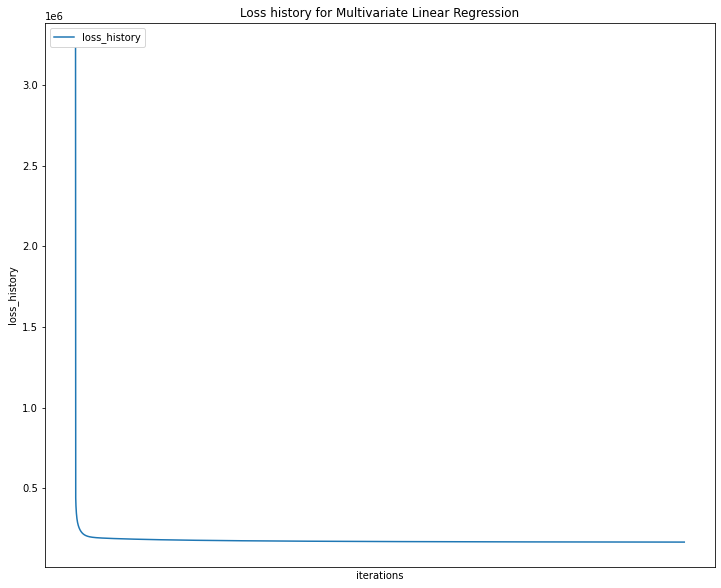

In [89]:
dataset = dataset_for_part_h
dataset.insert(0, "theta_0", np.ones(dataset.shape[0]))
feature_columns = dataset.drop('median_house_value', axis=1).columns

# print(">=========== split data to 60% train,20% validation and 20% test ===========<")
x_train, y_train, x_validation_test, y_validation_test = train_test_split(copy_df(dataset), train_size=.6, shuffle=True)
x_validation, y_validation, x_test, y_test = train_test_split(concat_data(x_validation_test, y_validation_test), test_size=.5, shuffle=True)

# convert all data to np array
x_train, y_train, x_validation, y_validation, x_test, y_test = np.array(x_train), np.array(y_train), np.array(x_validation), np.array(y_validation), np.array(x_test), np.array(y_test)

# add a column with all values 1 to the first column of x_train
# x_train = np.insert(x_train, 0, 1, axis=1) 
# print(">===========================================================================<")

# initialize theta with random values between 0 and 1
theta = np.random.rand(x_train.shape[1])
print("Intial theta shape: ", theta.shape[0], "\n", "Intial theta: ", theta)
print_hypothesis(x_train, theta)
y_train = y_train.reshape(y_train.shape[0],)
y_test = y_test.reshape(y_test.shape[0],)
y_validation = y_validation.reshape(y_validation.shape[0],)

theta, history_theta, loss_histoy = gradient_descent(x_train, y_train, x_validation, y_validation, theta, 0.5, .7, 10000)

y_predict = hypothesis(x_test, theta)
y_test = np.array(y_test).reshape(y_test.shape[0],)

report_error = pd.DataFrame({"mse": [calculate_mse(y_predict, y_test)], "rmse": [calculate_rmse(y_predict, y_test)], "mae": [
                            calculate_mae(y_predict, y_test)], "mape": [calculate_mape(y_predict, y_test)], "r_squared": [calculate_r_squared(y_predict, y_test)]})
print("Error on test set: \n", report_error)

coeffs = pd.DataFrame({"theta": history_theta[-1], "coeff": history_theta[-1]})
coeffs["coeff"] = coeffs["coeff"].apply(lambda x: np.round(x, 2))

# print(">===================== Figures =====================<")
# default plot
plt.figure(figsize=(11, 9))
plt.plot(range(len(coeffs)), coeffs)
plt.axhline(0, color='r', linestyle='solid')
plt.xticks(range(len(feature_columns)), feature_columns, rotation=50)
plt.ylabel("coefficients")
plt.xlabel("features")
plt.title("Coefficients for Multivariate Linear Regression")
plt.legend(["coefficients"], loc="upper left")
plt.show()

plt.figure(figsize=(12, 10))
plt.scatter(y_test, y_predict)
plt.plot([y_test.min(), y_test.max()], [
         y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions vs True Values', fontsize=20)
plt.show()

plt.figure(figsize=(12, 10))
plt.plot(range(len(loss_histoy)), loss_histoy)
# plt.axhline(0, color='r', linestyle='solid')
plt.xticks([])
# plt.xticks(range(len(loss_histoy)), range(len(loss_histoy)), rotation=50)
plt.xlabel("iterations")
plt.ylabel("loss_history")
plt.title("Loss history for Multivariate Linear Regression")
plt.legend(["loss_history"], loc="upper left")
plt.show()
# print(">===================================================<")

# Explanatory Data Analysis (EDA)

In [1]:
df = copy_df(dataset)

# Housing distribution on the map
plt.figure(figsize=(16,6))
fig = sns.scatterplot(df.longitude, df.latitude, hue=df['median_house_value'],
                      legend=False, palette='winter')

NameError: name 'copy_df' is not defined

## Correlation matrix

In [54]:
df.corr().style.background_gradient()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,median_house_value
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069260,0.099773,0.055310,-0.015176,0.321121,0.009446,-0.474489,0.045509,-0.045967
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066658,-0.108785,-0.071035,-0.079809,-0.446969,-0.016572,0.358771,-0.160818,-0.144160
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.318998,-0.296244,-0.302916,-0.119034,0.045300,0.017020,0.255172,0.021622,0.105623
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.927253,0.857126,0.918484,0.198050,-0.003031,-0.007572,-0.023022,-0.009175,0.134153
total_bedrooms,0.069260,-0.066658,-0.318998,0.927253,1.000000,0.873910,0.974725,-0.007682,0.018220,-0.004361,-0.019785,0.000676,0.049454
population,0.099773,-0.108785,-0.296244,0.857126,0.873910,1.000000,0.907222,0.004834,0.074613,-0.010412,-0.060880,-0.024264,-0.024650
households,0.055310,-0.071035,-0.302916,0.918484,0.974725,0.907222,1.000000,0.013033,0.042435,-0.009077,-0.010093,0.001714,0.065843
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007682,0.004834,0.013033,1.000000,0.168876,-0.009228,0.056197,0.027344,0.688075
ocean_proximity_<1H OCEAN,0.321121,-0.446969,0.045300,-0.003031,0.018220,0.074613,0.042435,0.168876,1.000000,-0.013872,-0.314813,-0.342620,0.256617
ocean_proximity_ISLAND,0.009446,-0.016572,0.017020,-0.007572,-0.004361,-0.010412,-0.009077,-0.009228,-0.013872,1.000000,-0.005499,-0.005985,0.023416


<AxesSubplot:title={'center':'Correlation Matrix'}, xlabel='Features'>

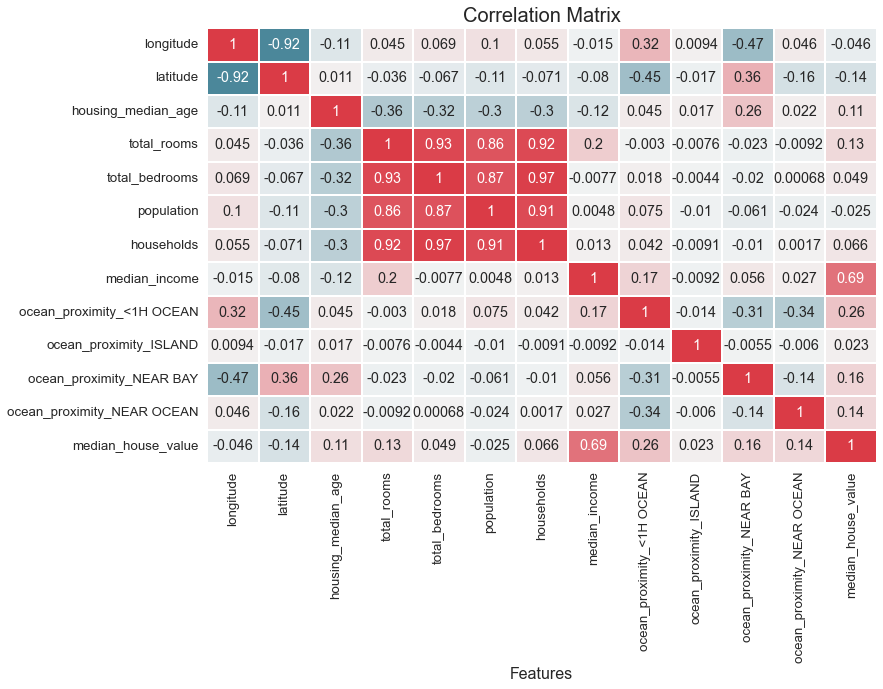

In [55]:
def correlation_heatmap(data):
    """arguments: data_frame:pandas DataFrame
       returns: correlation heatmap"""
    
    #  setting the context
    sns.set(context='paper', style='white', palette='deep', font='sans-serif', font_scale=1.5, color_codes=True)
    
    #  making correlation object and saving it into variable
    correlation = data.corr()
    
    #  creating heatmap figure object (paper) and ax object (the plot)
    fig, ax = plt.subplots(figsize=(12, 8))
    
    #  generating color palettes
    cmap = sns.diverging_palette(220, 10, center='light', as_cmap=True)
    
    #  draw the heatmap
    heatmap = sns.heatmap(correlation, vmax=1,vmin=-1,center=0, square=False, annot=True, cmap=cmap,
                         lw=2, cbar=False)
    
    # using fig and ax variables to set the title and labels
    heatmap.set_title('Correlation Matrix', fontsize=20)
    heatmap.set_xlabel('Features', fontsize=16)
    
    return heatmap

correlation_heatmap(df)

In [277]:
import os
import math
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

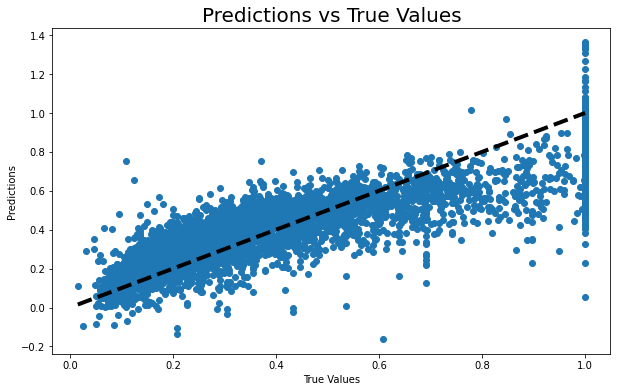

-0.02019783559016023
[0.42035925]
[ 0.         -0.56067197 -0.50103457  0.11987777 -0.32457138  0.85671214
 -2.74443547  0.97305853  1.15349471  0.07535157  0.52593851  0.07254744
  0.09313696]


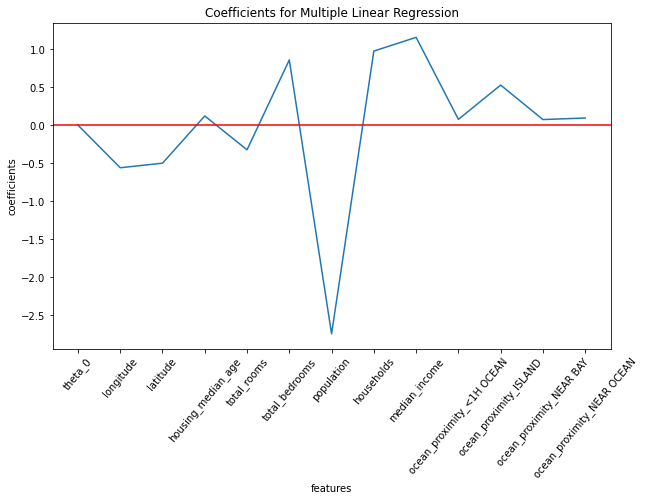

mse: [-0.01996657 -0.02264864 -0.02060919 -0.02194896 -0.01869898 -0.01931304
 -0.02040553 -0.02078052 -0.02039781 -0.0172091 ]


In [338]:
dataset = load("housing.csv")
dataset = normalize_missing_values(dataset)
last_column = dataset[["median_house_value"]]
dataset = remove_column(dataset, "median_house_value")

dataset = dummy_variable_indicator(dataset, "ocean_proximity")
dataset = remove_column(dataset, "ocean_proximity_INLAND")
dataset = concat_data(dataset, last_column)

dataset = normalize_numerical_columns(dataset)

dataset.insert(0, "theta_0", np.ones(dataset.shape[0]))

X = dataset.drop('median_house_value', axis=1)
y = dataset[['median_house_value']]

feature_columns = list(X.columns)

x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(X, y, test_size=.4)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5)

regressor = LinearRegression(fit_intercept=True)
model = regressor.fit(x_train, y_train)
y_predict = model.predict(x_test)

# plt.figure(figsize=(10,6))
# plt.scatter(y_test, y_predict)
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
# plt.xlabel('True Values')
# plt.ylabel('Predictions')
# plt.show()

y_predict = pd.DataFrame(y_predict, columns=["median_house_value"])
y_predict = y_predict.reset_index(drop=True)

# draw hyperplane for multivariate linear regression with y_predict and y_test
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_predict)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions vs True Values', fontsize=20)
plt.show()

mse = cross_val_score(model, x_train, y_train, scoring='neg_mean_squared_error', cv=10)
print(mse.mean())

multiple_lr_coeffs = model.coef_[0]
print(model.intercept_)
print(multiple_lr_coeffs)

plt.figure(figsize=(10,6))
plt.plot(range(len(multiple_lr_coeffs)),multiple_lr_coeffs)
plt.axhline(0, color='r', linestyle='solid')
plt.xticks(range(len(feature_columns)),feature_columns,rotation=50)
plt.title("Coefficients for Multiple Linear Regression")
plt.ylabel("coefficients")
plt.xlabel("features")
plt.show()

print("mse:", mse)

In [28]:
x_train.corr().style.background_gradient(cmap='coolwarm')

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
longitude,1.000000,-0.923981,-0.105167,0.040254,0.067978,0.099033,0.054140,-0.018263,0.318957,0.009828,-0.471625,0.039843
latitude,-0.923981,1.000000,0.008003,-0.032579,-0.065859,-0.108276,-0.069372,-0.077705,-0.448669,-0.016882,0.355986,-0.153636
housing_median_age,-0.105167,0.008003,1.000000,-0.360765,-0.318483,-0.293700,-0.300811,-0.117351,0.038559,0.018719,0.257925,0.030750
total_rooms,0.040254,-0.032579,-0.360765,1.000000,0.928249,0.856030,0.920379,0.198950,0.000073,-0.004257,-0.024612,-0.019292
total_bedrooms,0.067978,-0.065859,-0.318483,0.928249,1.000000,0.878468,0.982014,-0.011577,0.022405,0.000087,-0.021619,-0.010365
population,0.099033,-0.108276,-0.293700,0.856030,0.878468,1.000000,0.905168,0.002187,0.076275,-0.007894,-0.063179,-0.033262
households,0.054140,-0.069372,-0.300811,0.920379,0.982014,0.905168,1.000000,0.010285,0.043745,-0.006190,-0.012982,-0.008581
median_income,-0.018263,-0.077705,-0.117351,0.198950,-0.011577,0.002187,0.010285,1.000000,0.174705,-0.008851,0.053144,0.025225
ocean_proximity_<1H OCEAN,0.318957,-0.448669,0.038559,0.000073,0.022405,0.076275,0.043745,0.174705,1.000000,-0.013937,-0.317702,-0.335765
ocean_proximity_ISLAND,0.009828,-0.016882,0.018719,-0.004257,0.000087,-0.007894,-0.006190,-0.008851,-0.013937,1.000000,-0.005524,-0.005838


In [44]:
alpha_values = {'alpha':[0.001, 0.01,0.02,0.03,0.04, 0.05, 0.06, 0.07, 0.075, 0.08, 0.09,0.1,0.2,0.3,0.31,0.32,0.33,0.34, 0.35, 0.351, 0.352, 0.0353, 0.0354, 0.355 , 0.356 ,0.357, 0.358, 0.359 ,0.36, 0.37,0.38, 0.39, 0.4, 0.45, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 1, 2, 3, 5, 8, 10, 20, 50, 100]}
ridge= GridSearchCV(Ridge(), alpha_values, scoring='neg_mean_squared_error', cv=10 )
ridge.fit(x_train, y_train)
print(ridge.best_params_)

{'alpha': 0.3}


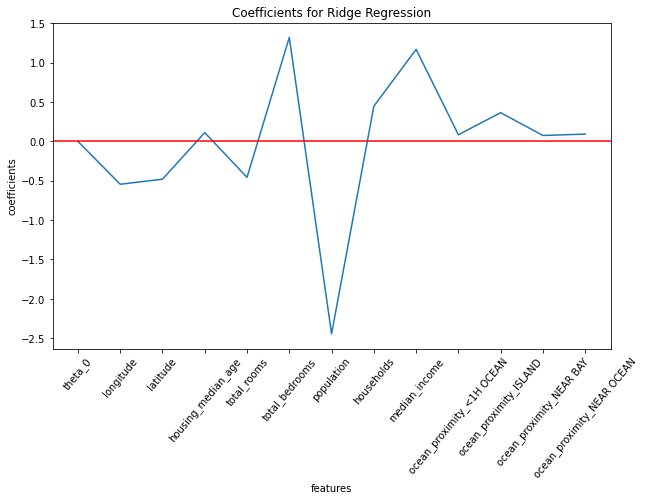

In [45]:
best_ridge_model= Ridge(alpha=ridge.best_params_['alpha'])
best_ridge_coeffs = best_ridge_model.fit(x_train, y_train).coef_
# print(best_ridge_coeffs)
#plot 
plt.figure(figsize=(10,6))
plt.plot(range(len(feature_columns)),best_ridge_coeffs[0])
plt.axhline(0, color='r', linestyle='solid')
plt.xticks(range(len(feature_columns)),feature_columns,rotation=50)
plt.title("Coefficients for Ridge Regression")
plt.ylabel("coefficients")
plt.xlabel("features")
plt.show()

In [46]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
alpha_values = {'alpha':[0.001, 0.01,0.02,0.03,0.04, 0.05, 0.06,0.07, 0.08, 1, 2, 3, 5, 8, 10, 20, 50, 100]}
lasso = GridSearchCV(Lasso(), alpha_values, scoring='neg_mean_squared_error', cv=10 )
lasso_fit = lasso.fit(x_train, y_train)
print(lasso_fit.best_params_)
print(lasso_fit.best_score_)

{'alpha': 0.001}
-0.02262223714466208


[ 0.         -0.01894358 -0.          0.08820824  0.          0.08105182
 -0.          0.          1.08835328  0.14311988  0.          0.15631366
  0.16910718]


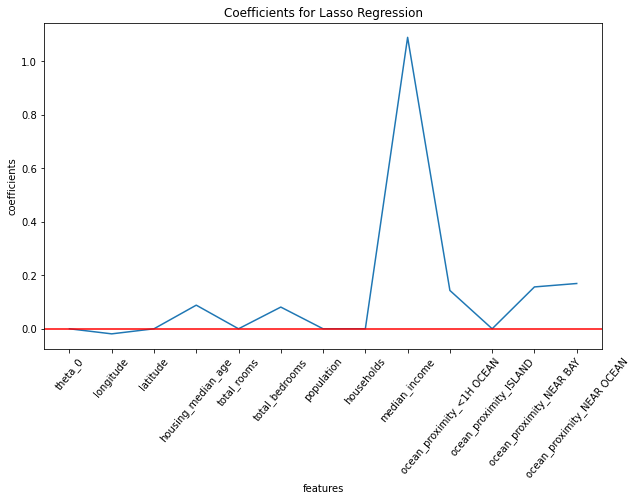

In [47]:
best_lasso_model= Lasso(alpha=lasso_fit.best_params_['alpha'])
best_lasso_coeffs = best_lasso_model.fit(x_train, y_train).coef_

print(best_lasso_coeffs)

# plot
plt.figure(figsize=(10,6))
plt.plot(range(len(feature_columns)),best_lasso_coeffs)
plt.axhline(0, color='r', linestyle='solid')
plt.xticks(range(len(feature_columns)),feature_columns,rotation=50)
plt.title("Coefficients for Lasso Regression")
plt.ylabel("coefficients")
plt.xlabel("features")
plt.show()


In [50]:
alpha_values = {'alpha':[0.01, 0.05, 0.06, 0.08, 1], 'l1_ratio':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1]}
elastic = GridSearchCV(ElasticNet(), alpha_values, scoring='neg_mean_squared_error', cv=10 )
elastic_fit = elastic.fit(x_train, y_train)
print(elastic_fit.best_params_)
print(elastic_fit.best_score_)

{'alpha': 0.01, 'l1_ratio': 0.1}
-0.025939313186586637


In [51]:
best_elastic_coeefs = elastic_fit.best_estimator_.coef_


In [52]:
# compare models with different regularization parameters
comparing_models = [('Linear Regression', LinearRegression()), ('Ridge Regression', Ridge()), ('Lasso Regression', Lasso()), ('Elastic Net', ElasticNet())]

comparing_models = pd.DataFrame({'without_regularization':multiple_lr_coeffs,
 'Ridge':best_ridge_coeffs[0],
 'Lasso':best_lasso_coeffs,
  'Elastic Net':best_elastic_coeefs}, index=feature_columns)
# Highlighting coefficient estimates with value '0'
comparing_models.style.background_gradient(cmap='coolwarm')

comparing_models

,without_regularization,Ridge,Lasso,Elastic Net
theta_0,0.000000,0.000000,0.000000,0.000000
longitude,-0.559328,-0.544001,-0.018944,-0.046550
latitude,-0.494833,-0.479799,-0.000000,-0.022790
housing_median_age,0.111586,0.111736,0.088208,0.046589
total_rooms,-0.520944,-0.456392,0.000000,0.010282
total_bedrooms,1.467754,1.322090,0.081052,0.003804
population,-2.780260,-2.444812,-0.000000,-0.000000
households,0.505994,0.447080,0.000000,0.000000
median_income,1.177032,1.169511,1.088353,0.697426
ocean_proximity_<1H OCEAN,0.082409,0.084638,0.143120,0.155535


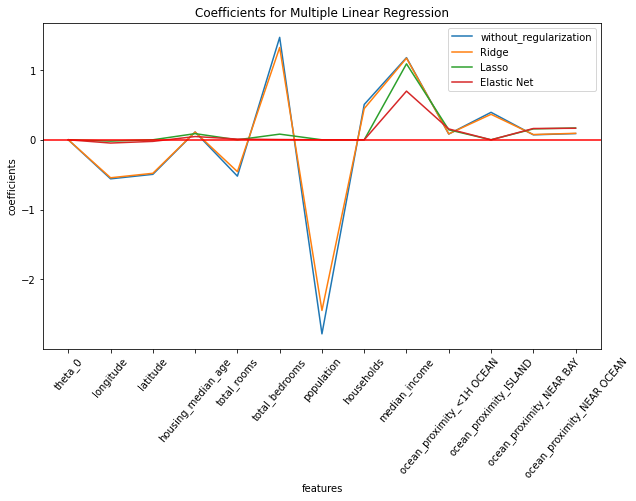

In [53]:
plt.figure(figsize=(10,6))
plt.plot(range(len(feature_columns)),comparing_models['without_regularization'], label='without_regularization')
plt.plot(range(len(feature_columns)),comparing_models['Ridge'], label='Ridge')
plt.plot(range(len(feature_columns)),comparing_models['Lasso'], label='Lasso')
plt.plot(range(len(feature_columns)),comparing_models['Elastic Net'], label='Elastic Net')
plt.axhline(0, color='r', linestyle='solid')
plt.xticks(range(len(feature_columns)),feature_columns,rotation=50)
plt.title("Coefficients for Multiple Linear Regression")
plt.ylabel("coefficients")
plt.xlabel("features")
plt.legend()
plt.show()

In [54]:
# solve same problem with neural network
from sklearn.neural_network import MLPRegressor
dataset = load("housing.csv")
dataset = normalize_missing_values(dataset)
last_column = dataset[["median_house_value"]]
dataset = remove_column(dataset, "median_house_value")
dataset = dummy_variable_indicator(dataset, "ocean_proximity")
dataset = remove_column(dataset, "ocean_proximity_INLAND")
dataset = concat_data(dataset, last_column)

# dataset = normalize_numerical_columns(dataset)

X = dataset.drop('median_house_value', axis=1)
y = dataset[['median_house_value']]

feature_columns = list(X.columns)

# split dataset into train, validation and test - 80% train, 10% validation and 10% test with sklearn

SEED = 42
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(
    X, y, test_size=.4, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(
    x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

mlp = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True,
                   random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

# fit the model with regularization
mlp.fit(x_train, y_train)
mlp.score(x_train, y_train)
mlp.score(x_validation, y_validation)
mlp.score(x_test, y_test)

print(mlp.coefs_)
print(mlp.intercepts_)

# predict the test set
y_pred = mlp.predict(x_test)


# MSE, MAE, R2
print("MSE: %.2f" % mean_squared_error(y_test, y_pred))
print("MAE: %.2f" % mean_absolute_error(y_test, y_pred))
print("R2: %.2f" % r2_score(y_test, y_pred))


[array([[-5.11102128e+000, -1.71822580e-254,  5.86142466e+000, ...,
        -5.39055068e+000, -5.01227186e+000, -5.22631462e+000],
       [ 4.05562547e+000, -3.49130830e-273, -4.49842810e+000, ...,
         3.93978498e+000,  4.35000674e+000,  4.23356753e+000],
       [ 6.42211023e+000, -4.52870805e-271, -7.39314647e+000, ...,
         6.68503340e+000,  6.47193697e+000,  6.53935933e+000],
       ...,
       [ 2.46704285e+000, -3.21640961e-261, -3.01627989e+000, ...,
         2.83813121e+000,  2.48706103e+000,  2.69973345e+000],
       [ 1.02965408e+001, -9.58854489e-255, -1.07375632e+001, ...,
         1.02996773e+001,  1.03020071e+001,  1.03424014e+001],
       [ 1.12568901e+001,  1.39841264e-253, -1.21066046e+001, ...,
         1.14618329e+001,  1.15424476e+001,  1.15510239e+001]]), array([[ 2.62653788e+000],
       [ 1.39076287e-278],
       [-3.48625538e+000],
       [ 2.41821780e+000],
       [ 2.47798243e+000],
       [ 1.98815050e+000],
       [ 2.11189142e+000],
       [ 5.55409

# Q2: Logistic Regression

In [295]:
def logistic(x_data, theta):
    return 1 / (1 + np.exp(-np.dot(x_data, theta)))

def hypothesis(x_data, weights):
    return logistic(x_data, weights)

def logistic_regression_regularized_loss(x_data, theta, lambda_):
    m_number_of_samples = len(x_data)
    j_theta_2 = lambda_/(2*m_number_of_samples) * np.sum(theta**2)
    return j_theta_2

def logistic_regression_loss(x_data, y_data, theta):
    m_number_of_samples = len(x_data)
    j_theta_1 = -1/m_number_of_samples * np.sum(y_data * np.log(logistic(x_data, theta)) + (1 - y_data) * np.log(1 - logistic(x_data, theta)))
    return j_theta_1

def loss_function(x_data, y_data, theta):
    """Loss Function without regularization
    @param x_data: train data
    @param y_data: train label
    @param theta: weights
    @return: loss function value
    """
    m_number_of_samples = x_data.shape[0]
    j_theta_1_mse_loss = np.sum(np.square(hypothesis(x_data, theta) - y_data)) / 2 * m_number_of_samples
    return j_theta_1_mse_loss

def gradient_descent(x_train, y_train, x_validation, y_validation, theta, regularization_parameter, alpha, max_iteration):
    """gradient_descent
    @param x_train: train data
    @param y_train: train label
    @param x_validation: validation data
    @param y_validation: validation label
    @param theta: wieghts
    @param regularization_paramet: lambda regularization parameter
    @param alpha: learning rate
    @param max_iteration: epochs
    @return: updated wieghts and loss function value
    """
    m_number_of_samples = x_train.shape[0]
    theta_dict = {}
    evaluation_with_validation_set_list = []

    with tqdm (total=max_iteration) as progress_bar:
        for iteration in range(max_iteration):
            hypothesis_value = hypothesis(x_train, theta)

            # updating θ_j with regularization
            for j_index in range(theta.shape[0]):
                if j_index != 0:
                    theta[j_index] -= alpha *  (1 / m_number_of_samples) * (np.dot(hypothesis_value - y_train, x_train[:, j_index]) + regularization_parameter * theta[j_index])
                else:
                    theta[j_index] -= alpha *  (1 / m_number_of_samples) * np.dot(hypothesis_value - y_train, x_train[:, j_index])

            evaluation_with_validation_set_list.append(loss_function(x_validation, y_validation, theta))
            theta_dict[iteration] = theta

            if len(evaluation_with_validation_set_list) >= 8:
                treshold_list = np.array(evaluation_with_validation_set_list[-8:])
                if treshold_list[-1 and -2 and -3 and -4 and -5 and -6 and -7] > treshold_list[-8]:

                    # if alpha > 1e-3:
                        # feedback = f"learning rate is too high, reducing it from {alpha}"
                        # alpha /= 2
                        # feedback += f" to {alpha} in iteration {iteration}"
                        # print(feedback)
                        # continue

                    print("iteration: ", iteration, "regularization_parameter: ", regularization_parameter, "alpha: ", alpha,  "loss: ", evaluation_with_validation_set_list[-1])
                    return theta, theta_dict, evaluation_with_validation_set_list

            if len(evaluation_with_validation_set_list) >= 10:
                plateau_list = np.array(evaluation_with_validation_set_list[-10:])
                if np.all(plateau_list == plateau_list[0]):
                    print("plateau: ", plateau_list)

                    print("iteration: ", iteration, "regularization_parameter: ", regularization_parameter, "alpha: ", alpha,  "loss: ", evaluation_with_validation_set_list[-1])
                    return theta, theta_dict, evaluation_with_validation_set_list

            progress_bar.update(1)
        print("regularization_parameter: ", regularization_parameter, "alpha: ", alpha,  "loss: ", evaluation_with_validation_set_list[-1])
    return theta, theta_dict, evaluation_with_validation_set_list




In [296]:
# print(">======================= Loading ====================<")
dataset = load("data_banknote_authentication.txt", False)
# print(">=====================================================")

# print(">============ Data without missing values ===========<")
dataset = normalize_missing_values(dataset)
dataset.rename(columns={0: 'column_1', 1: 'column_2', 2: 'column_3', 3: 'column_4', 4:'label' }, inplace=True)
# print_dataset(dataset)
# dataset.tail()
# print(">=====================================================")

# print(">============= Normalize numerical columns ==========<")
label_column = dataset[["label"]]
# dataset = remove_column(dataset, "label")
# dataset = normalize_numerical_columns(dataset)
# dataset = concat_data(dataset, label_column)
dataset.insert(0, "theta_0", np.ones(dataset.shape[0]))
feature_columns = dataset.drop('label', axis=1).columns
# print(">====================================================<")

# print(">=========== split data to 60% train,20% validation and 20% test ===========<")
x_train, y_train, x_validation_test, y_validation_test = train_test_split(copy_df(dataset), train_size=.6, shuffle=True)
x_validation, y_validation, x_test, y_test = train_test_split(concat_data(x_validation_test, y_validation_test), test_size=.5, shuffle=True)

# print(feature_columns, x_train.head())

x_train, y_train, x_validation, y_validation, x_test, y_test = np.array(x_train), np.array(y_train), np.array(x_validation), np.array(y_validation), np.array(x_test), np.array(y_test)
y_train, y_test, y_validation, = reshape_to_1d(y_train, y_test, y_validation)
# print(">====================================================<")

In [297]:
df_cv = dataset

In [298]:
# print(len(x_train), len(y_train), len(x_validation), len(y_validation), len(x_test), len(y_test))
# print(x_train)
# print(x_validation)
# print(x_test)
# print(y_train)

In [299]:
# print(">=================== Initialize theta with random values ===================<")
theta = np.random.rand(x_train.shape[1]) # random values between 0 and 1 
# theta = np.random.rand(x_train.shape[1]) * 5 + 5 # random values between 5 and 10
# theta = np.random.rand(x_train.shape[1]) * 1 + 2 # random values between 2 and 3

# regularization parameter lambda
regul_param_list = [0, 0.01, 0.1]
alpha_list = [.1, .3, .5, .7, .9, 1]
max_iteration = 10000
# print(">====================================================<")

def report_gradient_descent(x_train, y_train, x_validation, y_validation, theta, regularization_parameter_list, alpha_list, max_iteration):
    theta_list = []
    loss_list = []
    # report_dict_gradient_decent = pd.DataFrame(columns=["regularization_parameter", "alpha", "loss"])
    counter = 0 
    report_dict_gradient_decent = {}
    theta_value = np.random.rand(x_train.shape[1]) 
    for regularization_parameter in regularization_parameter_list:
        for alpha in alpha_list:
            theta = theta_value
            theta_, _, loss_histoy = gradient_descent(x_train, y_train, x_validation, y_validation, theta, regularization_parameter=regularization_parameter, alpha=alpha, max_iteration=max_iteration)
            loss_list.append(loss_histoy)
            theta_list.append({counter: [*theta_]})
            print("Coefficients: ", theta_list[counter])
            # report_dict_gradient_decent.loc[len(report_dict_gradient_decent)] = [regularization_parameter, alpha]
            
            print(">====================================================<")
            report_dict_gradient_decent[counter] = {
                "regularization_parameter": regularization_parameter,
                "alpha": alpha,
                "loss": loss_histoy
            }
            # print(report_dict_gradient_decent[counter])
            print(">====================================================<")
            
            counter += 1

    return report_dict_gradient_decent, theta_list, loss_list

report_dict, theta_list, loss_list = report_gradient_descent(x_train, y_train, x_validation, y_validation, theta, regul_param_list, alpha_list, max_iteration)

  0%|          | 0/10000 [00:00<?, ?it/s]

regularization_parameter:  0 alpha:  0.1 loss:  269.8311017541795
Coefficients:  {0: [3.8323891113021067, -4.183437063966889, -2.2123769842765033, -2.738003675537641, -0.22040801152276507]}
>====================================================<
>====================================================<


  0%|          | 0/10000 [00:00<?, ?it/s]

regularization_parameter:  0 alpha:  0.3 loss:  260.60563120247883
Coefficients:  {1: [5.2152492452123145, -5.992651296227391, -3.1198615693320146, -3.9066573925255987, -0.4250997180422512]}
>====================================================<
>====================================================<


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  281 regularization_parameter:  0 alpha:  0.5 loss:  260.6015808291861
Coefficients:  {2: [5.253039848210194, -6.041848927331795, -3.144639723398207, -3.9385326830764025, -0.43134709005101396]}
>====================================================<
>====================================================<


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  7 regularization_parameter:  0 alpha:  0.7 loss:  260.601595931828
Coefficients:  {3: [5.254515167467031, -6.043769359772503, -3.145607069862712, -3.939777052176718, -0.431591453859793]}
>====================================================<
>====================================================<


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  7 regularization_parameter:  0 alpha:  0.9 loss:  260.601634275958
Coefficients:  {4: [5.256409234311055, -6.046234856138061, -3.146848986108654, -3.941374614981653, -0.43190522753453536]}
>====================================================<
>====================================================<


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  7 regularization_parameter:  0 alpha:  1 loss:  260.6017016500156
Coefficients:  {5: [5.258510071841713, -6.0489694749600655, -3.1482264830161686, -3.9431465770995864, -0.4322533225309606]}
>====================================================<
>====================================================<


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  8722 regularization_parameter:  0.01 alpha:  0.1 loss:  259.8515451970087
Coefficients:  {6: [5.441496416584393, -6.272050070741896, -3.2599261192974756, -4.087566746947758, -0.4562985264060722]}
>====================================================<
>====================================================<


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  7 regularization_parameter:  0.01 alpha:  0.3 loss:  259.85154735120926
Coefficients:  {7: [5.4419351560042575, -6.272612365699133, -3.2602090328952515, -4.087931039398494, -0.45636776405298385]}
>====================================================<
>====================================================<


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  7 regularization_parameter:  0.01 alpha:  0.5 loss:  259.8515571127976
Coefficients:  {8: [5.442665848138451, -6.273548910154615, -3.260680256528244, -4.0885378022553835, -0.45648312906323607]}
>====================================================<
>====================================================<


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  7 regularization_parameter:  0.01 alpha:  0.7 loss:  259.85158368770743
Coefficients:  {9: [5.443687673229962, -6.2748587707294545, -3.2613393352515088, -4.089386440468148, -0.45664457313139384]}
>====================================================<
>====================================================<


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  7 regularization_parameter:  0.01 alpha:  0.9 loss:  259.85163973379923
Coefficients:  {10: [5.444999483702732, -6.276540636811858, -3.2621856297938274, -4.090476118218769, -0.45685202627931565]}
>====================================================<
>====================================================<


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  7 regularization_parameter:  0.01 alpha:  1 loss:  259.85173050967927
Coefficients:  {11: [5.446454445959984, -6.278406398588704, -3.263124503963997, -4.091684971681362, -0.4570823689467462]}
>====================================================<
>====================================================<


  0%|          | 0/10000 [00:00<?, ?it/s]

regularization_parameter:  0.1 alpha:  0.1 loss:  252.86949189977676
Coefficients:  {12: [5.344553815798142, -6.0140184338980776, -3.123387021027765, -3.9185215640065603, -0.382123052934147]}
>====================================================<
>====================================================<


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  44 regularization_parameter:  0.1 alpha:  0.3 loss:  252.86936067090468
Coefficients:  {13: [5.342531212930334, -6.011338783996273, -3.1220267228288496, -3.916776765601207, -0.38174586305964225]}
>====================================================<
>====================================================<


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  7 regularization_parameter:  0.1 alpha:  0.5 loss:  252.86939328565452
Coefficients:  {14: [5.341932614474303, -6.010547343861077, -3.121625104916921, -3.9162615277519417, -0.38163521526071076]}
>====================================================<
>====================================================<


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  7 regularization_parameter:  0.1 alpha:  0.7 loss:  252.86949194385897
Coefficients:  {15: [5.341095120351107, -6.009441242202045, -3.1210639220090046, -3.915541509462328, -0.3814811373303297]}
>====================================================<
>====================================================<


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  7 regularization_parameter:  0.1 alpha:  0.9 loss:  252.86970833210083
Coefficients:  {16: [5.340019300865898, -6.008022398547271, -3.120344256114173, -3.914618027047986, -0.38128444511050075]}
>====================================================<
>====================================================<


  0%|          | 0/10000 [00:00<?, ?it/s]

iteration:  7 regularization_parameter:  0.1 alpha:  1 loss:  252.87006502939002
Coefficients:  {17: [5.338825257782087, -6.006450261970468, -3.119547080878893, -3.9135949215888743, -0.38106773902197816]}
>====================================================<
>====================================================<


In [308]:
print(x_test.shape, y_test.shape)
# x_temp = np.array(x_validation_test)
# y_temp = np.array(y_validation_test).reshape(len(y_validation_test),)
x_temp = x_test.copy()
y_temp = y_test.copy()

print(x_temp.shape, y_temp.shape)

(275, 5) (275,)
(275, 5) (275,)


In [309]:
# def logistic_probability(x_data, theta):
    # return 1/(1 + math.e**(-(np.dot(x_data, theta))))

def predict(x_test, report_dict, theta_list, loss_list):
    y_predict_list = []
    alpha_lambda_list = []
    for index, value in report_dict.items():
        coeff_theta = [*theta_list[index].values()][0]
        y_predict_list.append(hypothesis(x_test, coeff_theta))
        alpha_lambda_list.append([value["alpha"], value["regularization_parameter"]])
    return y_predict_list, alpha_lambda_list, loss_list
    
y_predict_list, alpha_lambda_list, loss_list = predict(x_temp, report_dict, theta_list, loss_list)

# print(loss_list)

# for index, value in report_dict.items():
#     coeff_theta = [*theta_list[index].values()][0]
#     alpha = value["alpha"]
#     regularization_parameter = value["regularization_parameter"]
#     y_predict_list.append(logistic_probability(x_temp[:, 1], coeff_theta[1]))
#     y_predict_list[index]  = y_predict_list[index] + coeff_theta[0]
#     collect_list.append([alpha, regularization_parameter])

In [ ]:
collect_dict = {}

def plot_logistic_regression(x_test, y_test, y_predict, column_number):
    x_test[:, column_number] = x_test[:, column_number].astype(float)
    x_test[:, column_number] = np.sort(x_test[:, column_number])
    y_test = np.sort(y_test)
    y_predict = np.sort(y_predict)

    print(y_predict)

    x_range = np.linspace(x_test[:, column_number].min(), x_test[:, column_number].max(), x_test.shape[0])
    plt.plot(x_range, y_predict, 'k', label="logistic", lw=4)
    plt.scatter(x_test[:, column_number], y_test, label="scatter", color='g', s=50)
    plt.axhline(y=0.5, color='k')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc=2)
    plt.show()
    # plt.close()

plt.figure(figsize=(12, 10))
for index in range (1, len(y_predict_list)): # index 0 is x_0 = 1
    plot_logistic_regression(x_temp.copy(), y_temp.copy(), y_predict_list[index], 1)

In [ ]:
# for index in range(len(report_dict)):
    # plt.figure(figsize=(12, 10))
    # plt.plot(loss_list[index], label="loss")
    # # plt.plot(report_df.iloc[index]['loss'], label="loss")
    # plt.xlabel("Iteration")
    # plt.ylabel("Loss")
    # plt.legend(["Loss"], loc=4)
    # plt.title("Logistic Regression - loss graph - lambda: " + str(report_df.iloc[index]['regularization_parameter']) + " alpha: " + str(report_df.iloc[index]['alpha']))
    # # plt.savefig("./images/lambda_" + str(report_df.iloc[index]['regularization_parameter']) + "_alpha_" + str(report_df.iloc[index]['alpha']) + "_loss.png")
    # # plt.show()
    # plt.close()    

    # plt.plot(z, logistic(z), 'r', label='Theory')
    # plt.plot(Zs, Hs, 'o', label='empirical', markersize=8)
    # plt.plot(Zs, y, 'r_', label = 'data', markersize=8)
    # plt.xlabel('z')
    # plt.ylabel('h(z)')

    # plot logistic line
    # plt.figure(figsize=(12, 10))
    # print(x_test)
    # print(y_test)
    # print(hypothesis(x_temp, coeff_theta))
    # plt.plot(x_range, np.sort(hypothesis(x_temp, coeff_theta)), lw=4)

    # from scipy.special import expit

    # x_range = np.linspace(0, 1, x_temp.shape[0])

    # coeff_theta = [*theta_list[index].values()][0]
    # y_prediction = predict(x_temp, coeff_theta) 


    # yy = np.dot(x_temp[:, 1], coeff_theta[1]) + coeff_theta[0]
    # print(yy)

    # yy = np.dot(x_temp[:, 0], coeff_theta[0]))
    # plt.plot(x_range, np.sort(yy), lw=4)
    # print(yy.max(), yy.min())

    # x_range = np.linspace(x_temp[:,1].min(), x_temp[:,1].max(), x_temp.shape[0])
# 
    # yy = np.sort(predict_probability(x_range, coeff_theta[1])+ coeff_theta[0])

    # yy = (yy - yy.min())/(yy.max() - yy.min())
    # plt.plot(x_range, yy, color=np.random.rand(3,), markersize=8, label="lambda: " + str(collect_list[index][1]) + " alpha: " + str(collect_list[index][0]))



    # y_predict_list[index] = np.log(y_predict_list[index])

    # sigmoid = 1 / (1 + np.exp(-y_predict_list[index]))

    # y_predict_list[index] = np.where(y_predict_list[index] > 0.5, 1, 0)
    # sigmoid = 1 / (1 + np.exp(-y_predict_list[index]))


    # Normalize x_temp[:, 1] with np.interp
    # x_temp[:, 1] = np.interp(x_temp[:, 1], (x_temp[:, 1].min(), x_temp[:, 1].max()), (x_temp[:, 1].min(), x_temp[:, 1].max()))

    # normal x_temp[:, 1] distribution

    # make x_temp[:, 1] and y_temp to follow the same distribution
    # y_temp = np.interp(x_temp[:, 1], (x_temp[:, 1].min(), x_temp[:, 1].max()), (y_temp.min(), y_temp.max()))



    # y_predict_list[index] = np.repeat(y_predict_list[index], 10)

    # plt.plot(x_range, sigmoid, label='sigmoid', lw=4)

    
    # plt.plot(x_temp[:,1], sigmoid, 'g', label='data')
    # plt.legend(loc=4)
    # np.dot(x_range, coeff_theta)
    # y_predict = hypothesis(x_test, coeff_theta)
    # plt.scatter(x_temp[:, 1], y_test, c="g", label="test_dummy")
    # # plt.plot(
    # plt.xlabel("feature")
    # plt.ylabel("Probability")
    # plt.legend(["Test data", "Prediction"], loc=4)
    # plt.title("Logistic Regression - lambda: " + str(report_df.iloc[index]['regularization_parameter']) + " alpha: " + str(report_df.iloc[index]['alpha']))
    # plt.show()

# get median of x_temp[:,2]
# print(np.median(x_temp[:,2]))

# xx = np.round(x_temp[:, 1], 1)

# plt.axhline(y=0.5, color='k')
# plt.axvline(x=np.mean(x_temp[:,1]), color='k')
# plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
# plt.scatter(x_temp[:, 1], y_temp, label='data')
# plt.xlabel('x')
# plt.ylabel('y')
# # plt.title("Logistic Regression - lambda: " + str(report_df.iloc[index]['regularization_parameter']) + " alpha: " + str(report_df.iloc[index]['alpha']))
# # plt.savefig("./images/lambda_" + str(report_df.iloc[index]['regularization_parameter']) + "_alpha_" + str(report_df.iloc[index]['alpha']) + "_loss.png");
# plt.show()
# plt.close()
    

In [322]:
accuracy_orecision_recall_f_score_dict = {}

def confusion_matrix(y_true, y_pred):
    c_matrix = np.zeros((2, 2)) # 2x2 matrix as problem is 2-class
    for i in range(len(y_true)):
        if y_true[i] == 1 and y_pred[i] == 1: # TP
            c_matrix[0][0] += 1
        elif y_true[i] == 0 and y_pred[i] == 1: # FP
            c_matrix[0][1] += 1
        elif y_true[i] == 1 and y_pred[i] == 0: # FN
            c_matrix[1][0] += 1
        elif y_true[i] == 0 and y_pred[i] == 0: # TN
            c_matrix[1][1] += 1
        TP, FP, FN, TN = c_matrix[0][0], c_matrix[0][1], c_matrix[1][0], c_matrix[1][1]
    return TP, FP, FN, TN

# cm_result = confusion_matrix(collect_dict[0][0], collect_dict[0][1])

def show_metrics(confusion_result):
    TP, FP, FN, TN = confusion_result
    print("\nConfusion Matrix:")
    print("\t\tPredicted")
    print("\t\t\t0\t1")
    print("Actual")
    print("\t0\t\t{}\t{}".format(TP, FP))
    print("\t1\t\t{}\t{}".format(FN, TN))
    print(">===================================================<")
    print("Accuracy: ", np.round((TP + TN) / (TP + TN + FP + FN), 3))
    print("Precision: ", np.round(TP / (TP + FP), 3))
    print("Recall: ", np.round(TP / (TP + FN), 3))
    print("F1 Score: ", np.round(2 * TP / (2 * TP + FP + FN), 3))
# show_metrics(confusion_matrix_result)

def accuracy(confusion_matrix_result):
    TP, FP, FN, TN = confusion_matrix_result
    return np.round((TP + TN) / (TP + TN + FP + FN), 5)

def precision(confusion_matrix_result):
    TP, FP, FN, TN = confusion_matrix_result
    return np.round(TP / (TP + FP), 5)

def recall(confusion_matrix_result):
    TP, FP, FN, TN = confusion_matrix_result
    return np.round(TP / (TP + FN), 5)

def f_beta_score(confusion_matrix_result, beta=1):
    """
    ### Calculates the F-β score (the weighted harmonic mean of precision and recall).
    ### A perfect model has an F-score of 1.
    """
    TP, FP, FN, TN = confusion_matrix_result
    return np.round( (1 + beta**2) * TP / ((1 + beta**2) * TP + (beta**2) * FP + FN), 5)

for index in range(len(y_predict_list)):
    y_true = y_test
    y_pred = y_predict_list[index]
    # print(y_pred)

    alpha = alpha_lambda_list[index][0]
    regularization_parameter = alpha_lambda_list[index][1]

    cm = confusion_matrix(y_true, y_pred)
    show_metrics(cm)
    accuracy_orecision_recall_f_score_dict[index] = {
                        'alpha': alpha,
                        'regularization_parameter': regularization_parameter,
                        'accuracy': accuracy(cm),
                        'precision': precision(cm),
                        'recall': recall(cm),
                        'f1_score': f_beta_score(cm)
                        }

for key, value in accuracy_orecision_recall_f_score_dict.items():
    # report the metrics 
    print("alpha: ", value['alpha'], "lambda: ", value['regularization_parameter'] , "| accuracy: ", value['accuracy'], "| precision: ", value['precision'], "| recall: ", value['recall'], "| f1_score: ", value['f1_score'])

# print(collect_dict)
# [print(report_dict[key]) for key in report_dict]

# implement roc curve without sklearn
def roc_curve(y_true, y_pred):
    """
    ### Calculates the ROC curve and returns the AUC
    """
    pass


# Todo:
# implement ROC curve, AUC. 



Confusion Matrix:
		Predicted
			0	1
Actual
	0		0.0	0.0
	1		0.0	0.0
>===================================================<
Accuracy:  nan
Precision:  nan
Recall:  nan
F1 Score:  nan

Confusion Matrix:
		Predicted
			0	1
Actual
	0		0.0	0.0
	1		0.0	0.0
>===================================================<
Accuracy:  nan
Precision:  nan
Recall:  nan
F1 Score:  nan

Confusion Matrix:
		Predicted
			0	1
Actual
	0		0.0	0.0
	1		0.0	0.0
>===================================================<
Accuracy:  nan
Precision:  nan
Recall:  nan
F1 Score:  nan

Confusion Matrix:
		Predicted
			0	1
Actual
	0		0.0	0.0
	1		0.0	0.0
>===================================================<
Accuracy:  nan
Precision:  nan
Recall:  nan
F1 Score:  nan

Confusion Matrix:
		Predicted
			0	1
Actual
	0		0.0	0.0
	1		0.0	0.0
>===================================================<
Accuracy:  nan
Precision:  nan
Recall:  nan
F1 Score:  nan

Confusion Matrix:
		Predicted
			0	1
Actual
	0		0.0	0.0
	1		0.0	0.0
>====================

In [187]:
def k_fold_cross_validation(x_data, y_data, k_fold_number=5, shuffle=True):
    dataset = concat_data(x_data, y_data)
    if shuffle == True:
        dataset = dataset.sample(frac=1).reset_index(drop=True)
    dataset_size = len(dataset)
    fold_size = int(dataset_size / k_fold_number)
    
    # extract the data for each fold
    indices = np.arange(dataset_size)
    # use the indices to split the data into k folds
    for index in range(k_fold_number):
        if k_fold_number <= 1:
            x_train_set,y_train_set, x_test_set, y_test_set = train_test_split(dataset, test_size=0.4, random_state=0)
            train_set = concat_data(x_train_set, y_train_set)
            test_set = concat_data(x_test_set, y_test_set)
            print(train_set.shape, test_set.shape)
        else:        
            test_indices = indices[index * fold_size : (index + 1) * fold_size]
            train_indices =  np.delete(indices, test_indices)
            train_data = dataset.iloc[train_indices]
            test_data = dataset.iloc[test_indices]
            print(train_data.shape, test_data.shape)

        
    for index in range(k_fold_number):
        test_set = dataset
        train_set = dataset.drop(test_set.index)

    
    


x_data = df_cv.drop(['label'], axis=1)
label = df_cv[['label']]
score = k_fold_cross_validation(x_data, label, k_fold_number=5, shuffle=True)



# for index in range(len(score)):
#     print(score[index])

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24